# Indexing

In this script, we index the documents for the search engine that can be used later using `Search Engine.ipynb`.

### Important note

#### Download required files stored in Google Drive
This script requires the file `hydrated_tweets.json` that can be downloaded from the Google Drive Folder (`https://drive.google.com/drive/u/1/folders/16I4_ZCre59ufD9lDZbFK9cn1mALRmPjB`). The file must be stored in the `~/data` folder as specified in the README.

In [13]:
# We specify the path for importing modules
import sys
sys.path.append('../')

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from utils import clean_text, personalized_tokenizer

## Loading and Cleaning Dataset


In [15]:
# Read json data from the tweets
input_path = '../data/'
input_filename = 'hydrated_tweets.json'

In [16]:
# Generate a dataframe
df_tweets = pd.read_json(input_path + input_filename)

In [17]:
df_tweets.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorited,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,withheld_in_countries
0,2020-11-19 15:32:48+00:00,1329447539595227137,1329447539595227136,How Amazon and COVID-19 influence 2020 seasona...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://amplifr.com"" rel=""nofollow"">A...",NaN,NaN,...,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-11-19 15:32:48+00:00,1329447539658149888,1329447539658149888,Wow the U.S. already hit 250k+ deaths with COV...,False,"[0, 276]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,False,False,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-11-19 15:32:48+00:00,1329447542212452352,1329447542212452352,"Meanwhile, Air Canada is booking flights from ...",False,"[0, 118]","{'hashtags': [{'text': 'RDU', 'indices': [46, ...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-11-19 15:32:48+00:00,1329447542405406721,1329447542405406720,@JMinnga @CNNnewsroom @jaketapper @CNN This wo...,False,"[39, 165]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",1.329444e+18,1.329444e+18,...,False,False,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-11-19 15:32:49+00:00,1329447545320443904,1329447545320443904,@ScottinBayV To believe what these outliers in...,False,"[13, 168]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",1.329400e+18,1.329400e+18,...,False,False,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_tweets['full_text'][0]

'How Amazon and COVID-19 influence 2020 seasonal hiring trends https://t.co/dKT2idSP0J'

In [19]:
# First, we want to delete all RT to avoid duplicate content and show the original tweet when searching
print("Original dataset size: {}".format(len(df_tweets)))
df_tweets = df_tweets.loc[~df_tweets['full_text'].str.startswith("RT")]
print("Dataset size after removing RTs: {}".format(len(df_tweets)))

Original dataset size: 96359
Dataset size after removing RTs: 96359


In our case, our dataset was filtered in the streamer to avoid RTs.

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/javi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
 # Then, we clean the resulting tweets
df_tweets['clean_text'] = df_tweets['full_text'].apply(lambda x: clean_text(x))
df_tweets.head(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,withheld_in_countries,clean_text
0,2020-11-19 15:32:48+00:00,1329447539595227137,1329447539595227136,How Amazon and COVID-19 influence 2020 seasona...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://amplifr.com"" rel=""nofollow"">A...",NaN,NaN,...,False,0.0,en,NaN,NaN,NaN,NaN,NaN,NaN,amazon covid19 influenc 2020 season hire trend
1,2020-11-19 15:32:48+00:00,1329447539658149888,1329447539658149888,Wow the U.S. already hit 250k+ deaths with COV...,False,"[0, 276]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,False,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,wow us alreadi hit 250k death covid 84 911 att...


In [22]:
# Show sample cleaning procedure for first tweets.

for i in range(4):
    print("Original tweet: {}".format(df_tweets.iloc[i]['full_text']))
    print("Clean tweet: {}".format(df_tweets.iloc[i]['clean_text']))
    print("------\n")

Original tweet: How Amazon and COVID-19 influence 2020 seasonal hiring trends https://t.co/dKT2idSP0J
Clean tweet: amazon covid19 influenc 2020 season hire trend
------

Original tweet: Wow the U.S. already hit 250k+ deaths with COVID. This is more than:

- 84 9/11 attacks
- 4,311 Las Vegas shootings (2017)
- 9,260 Sandy hook shootings (2012)
- 11,364 El Paso shootings (2019)
- 2 WW1 deaths (233,032)

This is so sad. Hearts out to those who lost a loved one.
Clean tweet: wow us alreadi hit 250k death covid 84 911 attack 4311 la vega shoot 2017 9260 sandi hook shoot 2012 11364 el paso shoot 2019 2 ww1 death 233032 sad heart lost love one
------

Original tweet: Meanwhile, Air Canada is booking flights from #RDU in January. #travel #coronavirus #COVID19 

https://t.co/lbubQ0G0cl
Clean tweet: meanwhil air canada book flight #rdu januari #travel #coronavirus #covid19
------

Original tweet: @JMinnga @CNNnewsroom @jaketapper @CNN This women has to go to food banks bc of covid lockdowns but 

In [23]:
df_tweets.columns

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted',
       'possibly_sensitive', 'lang', 'extended_entities', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status_permalink', 'quoted_status',
       'withheld_in_countries', 'clean_text'],
      dtype='object')

In [24]:
# Remove empty documents after cleaning
df_tweets = df_tweets[df_tweets['clean_text']!='']

In [25]:
df_tweets.shape

(95925, 32)

In [26]:
df_tweets['clean_text'].values[0]

'amazon covid19 influenc 2020 season hire trend'

In [33]:
# Include followers count
def get_followers_count(user):
    return eval(user)['followers_count']

In [34]:
df_tweets['followers_count'] = df_tweets.user.apply(get_followers_count)

In [35]:
# Checkpoint
# df_tweets.to_csv(input_path+'df_tweets.csv')
# df_tweets = pd.read_csv(input_path+'df_tweets.csv', index_col=0)

# Inverted index generation

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df_tweets['clean_text']
vectorizer = TfidfVectorizer(tokenizer = personalized_tokenizer, lowercase=False)
tf_idf = vectorizer.fit_transform(corpus)

In [31]:
mapping = vectorizer.vocabulary_
print('Example of mapping. Amen-> ',mapping['amen'])
print("We have {} terms in our vocabulary".format(len(mapping)))

Example of mapping. Amen->  17810
We have 58450 terms in our vocabulary


In [32]:
tf_idf_tokens = vectorizer.get_feature_names() # Get the words
df_tfidf = pd.DataFrame.sparse.from_spmatrix(data=tf_idf, columns=tf_idf_tokens) # Dataframe each row is a doc and each col a word
df_tfidf.shape

(95925, 58450)

In [33]:
# Include the doc_id
df_tfidf['rdoc_id'] = list(df_tweets['id_str'].values)
df_tfidf = df_tfidf.set_index('rdoc_id', drop=True)
df_tfidf.head()

,#,#009,#0f8391b2491b54189769942f6d267ce2,#1,#10,#100,#100000,#1000miglia,#100milesin100swims,#10daystokai,...,zumberg,zur,zurich,zut,zvakubata,zw1,zweig,zweli,zydu,zzx
rdoc_id,,,,,,,,,,,,,,,,,,,,,
1329447539595227136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1329447539658149888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1329447542212452352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1329447542405406720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1329447545320443904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Transform matrix into dictionary containing for each word the doc where it appears
inverted_index = {}

for col in df_tfidf.columns:
    temp = df_tfidf[col]
    temp = temp[temp!=0]
    inverted_index[col] = list(zip(temp.index,temp))

In [35]:
print("Length of the inverted index = {}".format(len(inverted_index)))

Length of the inverted index = 58450


In [36]:
# Sample of inverted index for a term
inverted_index['#1000miglia']

[(1329459679861338112, 0.3299102849849904)]

In [37]:
# Store inverted index
with open(input_path + 'inverted_index.json', 'w') as fp:
    json.dump(inverted_index, fp)

In [38]:
# Store vectorizer for later use
import pickle
pickle.dump(vectorizer, open(input_path + "vectorizer.pickle", "wb"))

# Incorporate Authority
Now, we will compute the authority for our tweets and store them separately. The authority will be based in RT and FAV count as well as followers.

In [28]:
# Load tweets
df_tweets = pd.read_csv(input_path+'df_tweets.csv', index_col=0)

/Users/javi/miniconda3/envs/upf/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [36]:
df_tweets.columns

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted',
       'possibly_sensitive', 'lang', 'extended_entities', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status_permalink', 'quoted_status',
       'withheld_in_countries', 'clean_text', 'followers_count'],
      dtype='object')

In [37]:
# use retweet_count/ favorite_count / user field -> followers_count / reply_count / quote_count
def calculate_authority(rt: float, fav: int ,foll: int, w: list):
    if sum(w) !=  1:
        raise Exception('Error: Weights not summing up to 1')
    else:
        sum_weights =  min(foll, 5000)*w[2] + rt*w[0] + fav*w[1]
        if sum_weights > 1: # Instead of negative value for values smaller than 1 we return 0
            return np.log(sum_weights) # Sum to avoid 0
        return 0

weights = [0.475, 0.475, 0.05] # retweet_count/ favorite_count / followers_count -> must sum up to 1

df_tweets['authority']  = df_tweets.apply(lambda x: calculate_authority(x['retweet_count'],
                                                                        x['favorite_count'],
                                                                        x['followers_count'],
                                                                        weights),axis=1)

In [38]:
df_tweets.authority.max()

11.883889876433964

<AxesSubplot:>

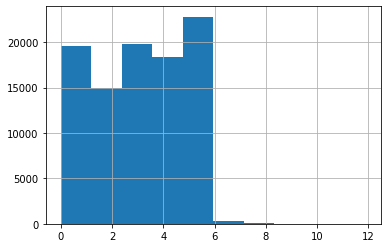

In [39]:
df_tweets.authority.hist()

Now, we will interpolate our authority between 0 and 1 to dump its importance.

In [40]:
df_tweets['authority_interp'] = np.interp(df_tweets.authority.values, (df_tweets.authority.values.min(), df_tweets.authority.values.max()), (0, 1))

<AxesSubplot:>

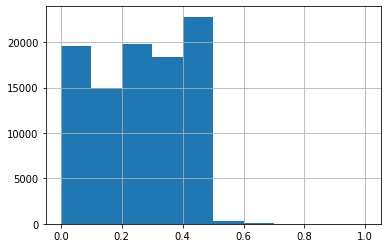

In [41]:
df_tweets.authority_interp.hist()

In [42]:
# df_tweets.to_csv(input_path + 'tweets_with_authority.csv')